In [210]:
import math
import time
import numpy as np
import json
import glob
import warnings
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)


import datetime



# Import der Daten

In [211]:
# import required module
import os
# assign directory
directory = '../data/DatenSisag/Verkehrsdaten/Rohdaten Auswertungfiles xls/all'
dflist = {}
messstelle = ""

# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        if filename.startswith("ok_") :
            messstelle =  filename[3:7]
        else:
            messstelle = filename[0:3]
        dflist[messstelle]=pd.read_excel(f)
        break


../data/DatenSisag/Verkehrsdaten/Rohdaten Auswertungfiles xls/all\5401_2022.xlsx


In [244]:
df_silenen_amsteg = pd.read_excel('C:/Users/enriq/Desktop/uri_verkehr/data/DatenSisag/Verkehrsdaten/Rohdaten Auswertungfiles xls/2022/7403_2022.xlsx')
df_erstfeld_silenen = pd.read_excel('C:/Users/enriq/Desktop/uri_verkehr/data/DatenSisag/Verkehrsdaten/Rohdaten Auswertungfiles xls/2022/7201_2022.xlsx')

# Datumszeile erstellen

In [245]:
def anpassung_zeit(df):
    df.HHMM = df.HHMM / 100
    df['HHMM']=df['HHMM'].replace(24.0,23.59)
    df.head(100)
    df['Datum und Zeit'] = df["Datum"].astype(str)+ ' ' +df.HHMM.astype(str)
    df['Datumszeit'] = pd.to_datetime(df['Datum und Zeit'], format='%Y-%m-%d %H.%M')
    return df
df_erstfeld_silenen = anpassung_zeit(df_erstfeld_silenen)
df_silenen_amsteg = anpassung_zeit(df_silenen_amsteg)
df_silenen_amsteg

,Zst,Datum,HHMM,Richtung,-,Klasse,CS 1,CS 2,CS 3,CS 4,CS 5,CS 6,CS 7,CS 8,CS 9,CS10,Day Helper,Month Helper,Querschnitt,Wochenende/Feirtag,Datum und Zeit,Datumszeit
0,7403,2022-02-12,1.00,1,0,1,0,2,1,0,NaN,NaN,NaN,NaN,NaN,NaN,7,2,NaN,x,2022-02-12 1.0,2022-02-12 01:00:00
1,7403,2022-02-12,1.00,1,0,2,1,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,3.0,x,2022-02-12 1.0,2022-02-12 01:00:00
2,7403,2022-02-12,1.00,2,0,1,0,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,7,2,NaN,x,2022-02-12 1.0,2022-02-12 01:00:00
3,7403,2022-02-12,1.00,2,0,2,1,0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,7,2,4.0,x,2022-02-12 1.0,2022-02-12 01:00:00
4,7403,2022-02-12,2.00,1,0,1,0,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,7,2,NaN,x,2022-02-12 2.0,2022-02-12 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,7403,2022-04-30,23.00,2,0,2,2,0,22,0,0.0,0.0,0.0,0.0,0.0,0.0,7,4,24.0,x,2022-04-30 23.0,2022-04-30 23:00:00
35036,7403,2022-04-30,23.59,1,0,1,0,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,7,4,NaN,x,2022-04-30 23.59,2022-04-30 23:59:00
35037,7403,2022-04-30,23.59,1,0,2,1,0,9,0,0.0,0.0,0.0,0.0,0.0,0.0,7,4,10.0,x,2022-04-30 23.59,2022-04-30 23:59:00
35038,7403,2022-04-30,23.59,2,0,1,0,8,1,0,NaN,NaN,NaN,NaN,NaN,NaN,7,4,NaN,x,2022-04-30 23.59,2022-04-30 23:59:00


df1.HHMM = df1.HHMM / 100
df1['HHMM']=df1['HHMM'].replace(24.0,0.0)
df1.head(100)
df1['Datum und Zeit'] = df1["Datum"].astype(str)+ ' ' +df1.HHMM.astype(str)
df1['Datumszeit'] = pd.to_datetime(df1['Datum und Zeit'], format='%Y-%m-%d %H.%M')

In [246]:
def delete_rows(df):
    df = df[["Querschnitt","Datumszeit", "Richtung"]]
    df = df[df['Querschnitt'].notna()]
    return df

df_erstfeld_silenen = delete_rows(df_erstfeld_silenen)
df_silenen_amsteg = delete_rows(df_silenen_amsteg)
df_silenen_amsteg

,Querschnitt,Datumszeit,Richtung
1,3.0,2022-02-12 01:00:00,1
3,4.0,2022-02-12 01:00:00,2
5,3.0,2022-02-12 02:00:00,1
7,1.0,2022-02-12 02:00:00,2
9,4.0,2022-02-12 03:00:00,1
...,...,...,...
35031,24.0,2022-04-30 22:00:00,2
35033,10.0,2022-04-30 23:00:00,1
35035,24.0,2022-04-30 23:00:00,2
35037,10.0,2022-04-30 23:59:00,1


In [247]:
df_erstfeld_silenen = df_erstfeld_silenen[["Querschnitt","Datumszeit"]]
df_erstfeld_silenen = df_erstfeld_silenen[df_erstfeld_silenen['Querschnitt'].notna()]

df_silenen_amsteg = df_silenen_amsteg[["Querschnitt","Datumszeit"]]
df_silenen_amsteg = df_silenen_amsteg[df_silenen_amsteg['Querschnitt'].notna()]

df_erstfeld_silenen

,Querschnitt,Datumszeit
1,11.0,2022-01-01 01:00:00
3,12.0,2022-01-01 01:00:00
5,11.0,2022-01-01 02:00:00
7,15.0,2022-01-01 02:00:00
9,12.0,2022-01-01 03:00:00
...,...,...
32287,15.0,2022-12-31 22:00:00
32289,12.0,2022-12-31 23:00:00
32291,11.0,2022-12-31 23:00:00
32293,12.0,2022-12-31 23:59:00


In [249]:
def aufsummieren(df):
    df = df.groupby(df['Datumszeit'].dt.date)['Querschnitt'].sum()
    df = df.to_frame(name='Querschnitt').reset_index()
    return df

df_erstfeld_silenen = aufsummieren(df_erstfeld_silenen)
df_silenen_amsteg = aufsummieren(df_silenen_amsteg)

AttributeError: Can only use .dt accessor with datetimelike values

In [254]:
df = df_erstfeld_silenen.merge(df_silenen_amsteg, left_on='Datumszeit', right_on='Datumszeit')

In [255]:
df

,Datumszeit,Querschnitt_x,Querschnitt_y
0,2022-01-01,1434.0,1067.0
1,2022-01-02,1524.0,1139.0
2,2022-01-03,2285.0,1279.0
3,2022-01-04,2238.0,1284.0
4,2022-01-05,2176.0,1369.0
...,...,...,...
332,2022-12-27,2347.0,2594.0
333,2022-12-28,2270.0,1377.0
334,2022-12-29,2253.0,1325.0
335,2022-12-30,2374.0,1416.0


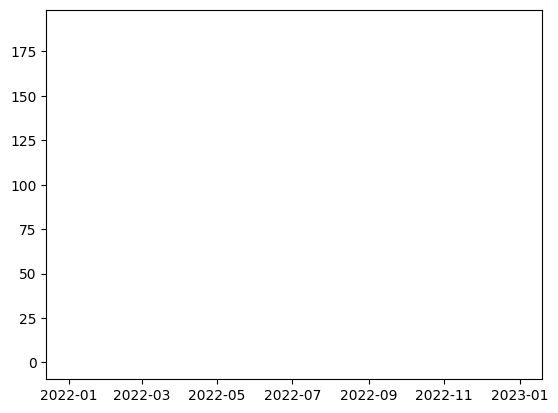

In [ ]:
import matplotlib.pyplot as plt
from data_formatting import Data
import uuid

device_id = str(uuid.getnode())
if device_id == "101707883750031":  # Julian
    local_path = 'C://Users//taseehol//PycharmProjects//uri_verkehr//data//DatenSisag//Verkehrsdaten//Rohdaten Auswertungfiles xls//2022'
else:  # somebody else
    local_path = 'C://Users//enriq//Desktop//uri_verkehr//data//DatenSisag//Verkehrsdaten//Rohdaten Auswertungfiles xls//2022'

csvs = ['6004_2022.xlsx']

fig, ax = plt.subplots()

plot_data = Data(csvs, local_path)
ax.plot(plot_data.datetimes[0], plot_data.dataframes[0]['Querschnitt'], label='6004_2022')
plt.show()

In [235]:
df

,Querschnitt_x,Datumszeit,Richtung_x,Querschnitt_y,Richtung_y
0,11.0,2022-01-01 01:00:00,1,4.0,1
1,11.0,2022-01-01 01:00:00,1,3.0,2
2,12.0,2022-01-01 01:00:00,2,4.0,1
3,12.0,2022-01-01 01:00:00,2,3.0,2
4,11.0,2022-01-01 02:00:00,1,11.0,1
...,...,...,...,...,...
32295,11.0,2022-12-31 23:00:00,2,4.0,2
32296,12.0,2022-12-31 23:59:00,1,3.0,1
32297,12.0,2022-12-31 23:59:00,1,3.0,2
32298,8.0,2022-12-31 23:59:00,2,3.0,1


In [251]:
import plotly.express as px
fig = px.line(df_erstfeld_silenen, y='Querschnitt',x="Datumszeit", hover_data=["Datumszeit"])
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [ ]:
import plotly.express as px
fig = px.line(df_silenen_amsteg, y='Querschnitt',x="Datumszeit", hover_data=["Datumszeit"])

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()